In [42]:
import math
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

# Step 1. Dataset

Dataset link: https://www.kaggle.com/datasets/yasserh/song-popularity-dataset

Dataset description: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

In [21]:
data = pd.read_csv('song_data.csv')

In [22]:
data.columns

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [23]:
data.shape

(18835, 15)

C:\Users\admin\AppData\Local\Temp\ipykernel_4840\1557587837.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax=ax, bins=30)


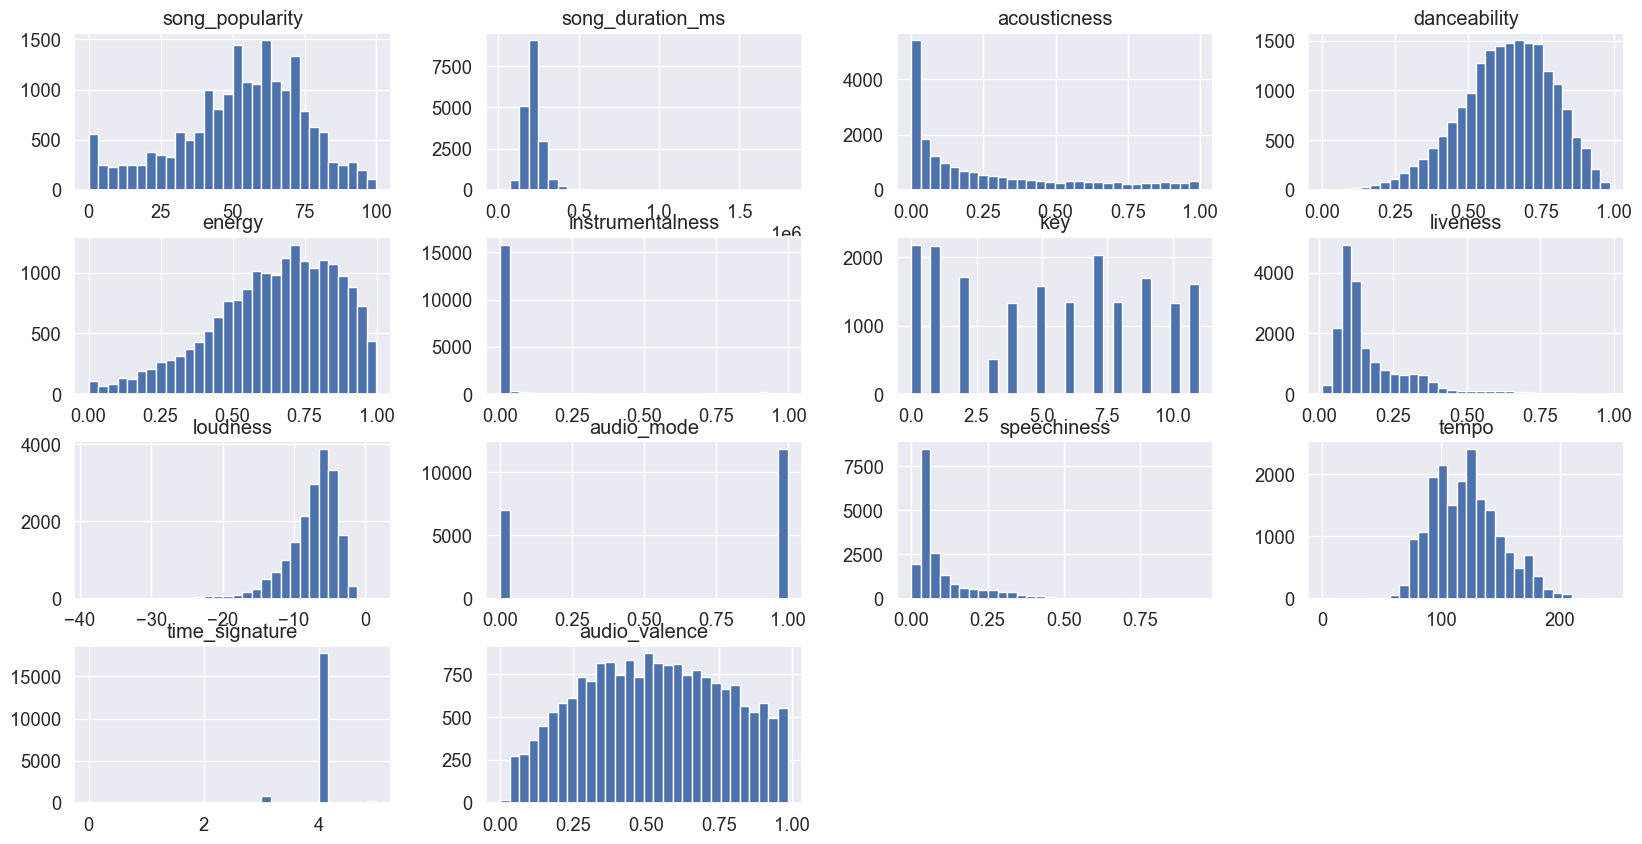

In [24]:
figure, ax = plt.subplots(figsize=(20, 10))
data.hist(ax=ax, bins=30)
plt.savefig('all_data_hist.png')

In [25]:
data.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [27]:
danceability = data.danceability 
energy = data.energy
loudness = data.loudness

# Step 2. Histogrames

In [28]:
def bins_num(sample):
  n = len(sample)
  return int(5 * math.log(n))

In [29]:
sns.set(font_scale=1.7)

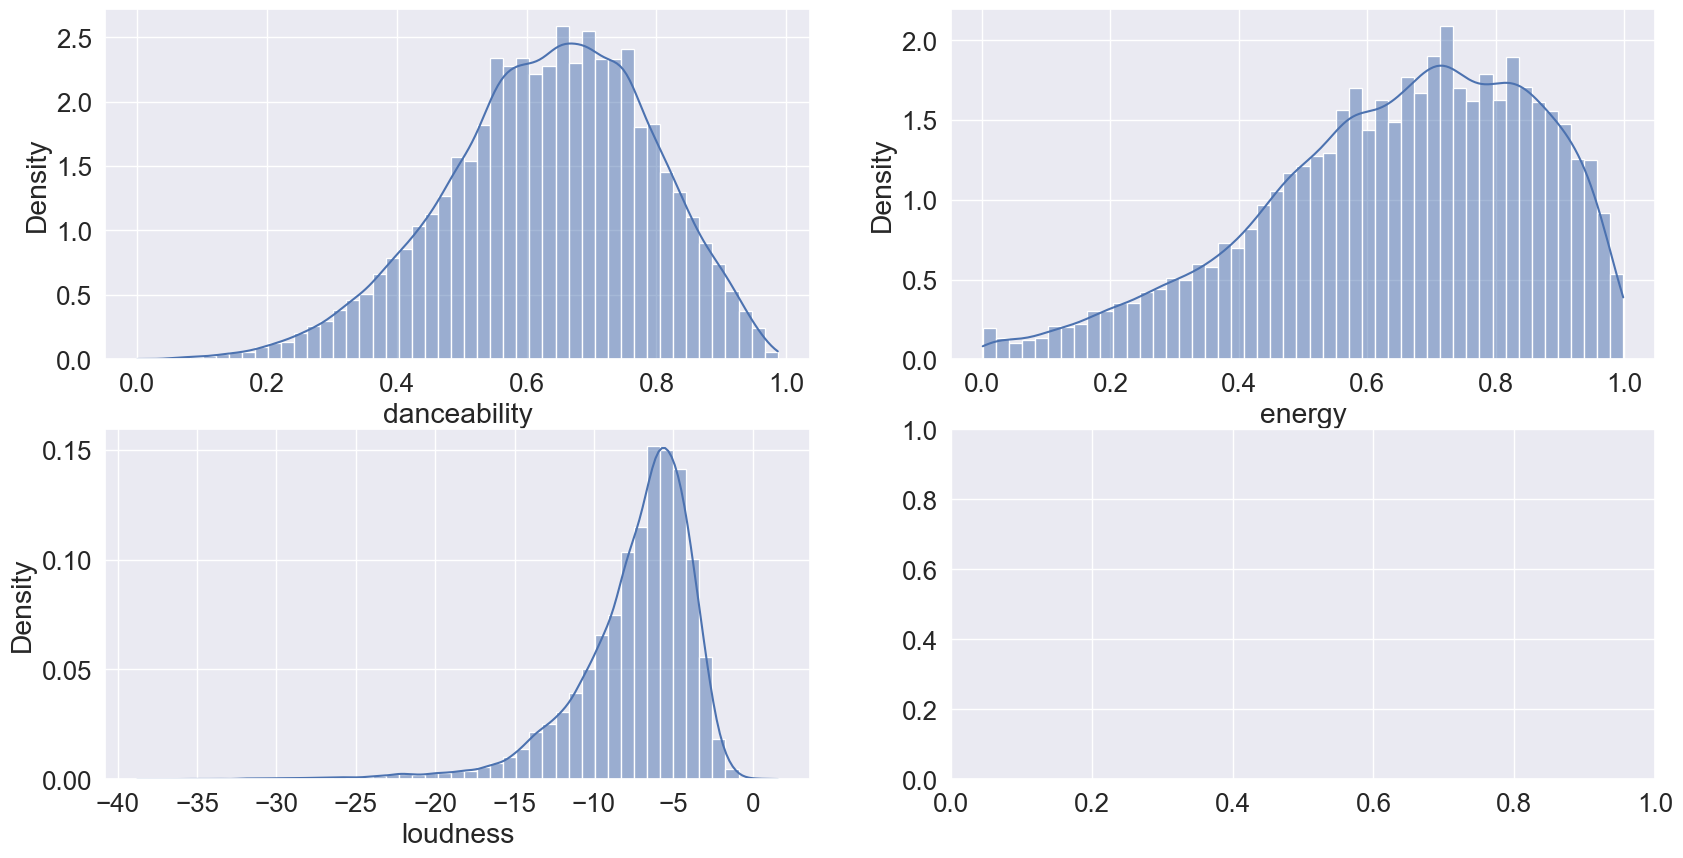

In [30]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.rcParams['font.size'] = '14'

sns.histplot(data=danceability, kde=True, ax=ax[0, 0], bins=bins_num(danceability), stat='density')

sns.histplot(data=energy, kde=True, ax=ax[0, 1], bins=bins_num(energy), stat='density')

sns.histplot(data=loudness, kde=True, ax=ax[1, 0], bins=bins_num(loudness), stat='density')

plt.savefig('rv_hist.png')

# Step 3. Boxplots

In [31]:
def quantiles(sample: pd.Series) -> dict:
  quantiles = [0, 0.25, 0.5, 0.75, 1]
  result ={}
  for quantile in quantiles:
    value = sample.quantile(quantile)
    result.update({f'Quantile {quantile}': value})
  return result

def print_quantiles(sample: pd.Series):
  print(sample.name, '\n')
  print(pd.Series(data=quantiles(sample), name='quantiles'))

sns.set(font_scale=1.3)

danceability 

Quantile 0       0.000
Quantile 0.25    0.533
Quantile 0.5     0.645
Quantile 0.75    0.748
Quantile 1       0.987
Name: quantiles, dtype: float64


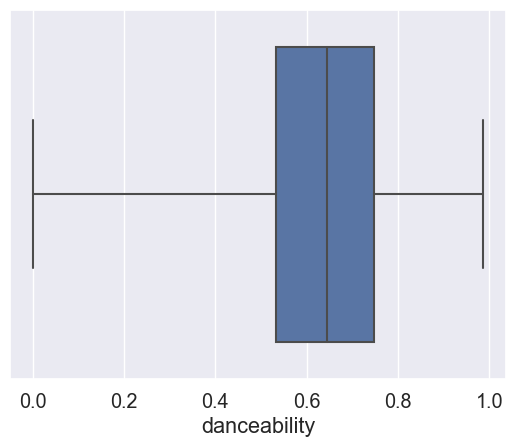

In [32]:
print_quantiles(danceability)
sns.boxplot(x=danceability, whis=100)
plt.savefig('danceability_boxplot.png')

energy 

Quantile 0       0.00107
Quantile 0.25    0.51000
Quantile 0.5     0.67400
Quantile 0.75    0.81500
Quantile 1       0.99900
Name: quantiles, dtype: float64


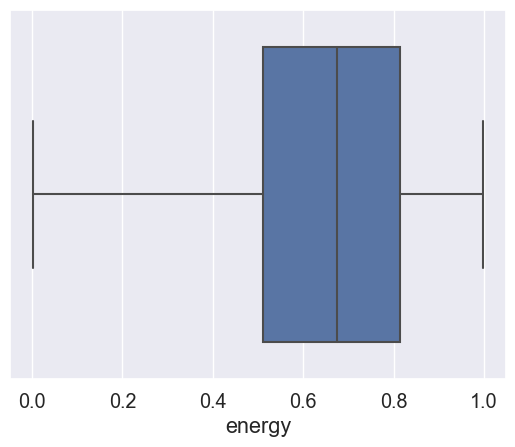

In [33]:
print_quantiles(energy)
sns.boxplot(x=energy, whis=100)
plt.savefig('energy_boxplot.png')

loudness 

Quantile 0      -38.768
Quantile 0.25    -9.044
Quantile 0.5     -6.555
Quantile 0.75    -4.908
Quantile 1        1.585
Name: quantiles, dtype: float64


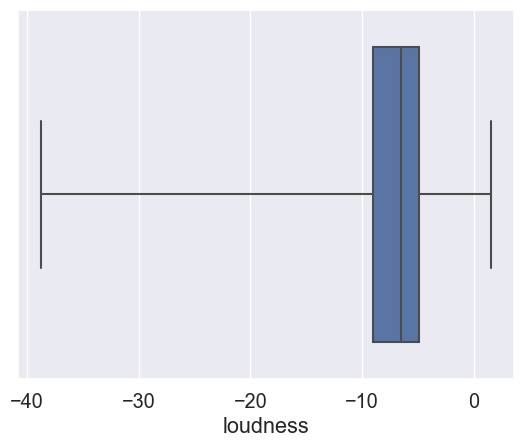

In [34]:
print_quantiles(loudness)
sns.boxplot(x=loudness, whis=100)
plt.savefig('loudness_boxplot.png')

# Step 4. Distribution

In [35]:
def plot_dist(sample: pd.Series, dist):
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))
  sns.set(font_scale=2)
  plt.rcParams['font.size'] = '20'
  sns.histplot(data=sample, kde=True, ax=ax, bins=bins_num(sample), stat='density', label='sample random variates')
  
  params = dist.fit(sample)
  print(params)
  x = np.linspace(sample.min(), sample.max(), 100)
  y = dist.pdf(x, *params)
  ax.plot(x, y, 'r-', lw=2, label=type(dist).__name__)
  plt.legend()
  plt.show()


(8.852157710187019, 4.078166268703384, -0.23037409700995667, 1.2617187963082035)


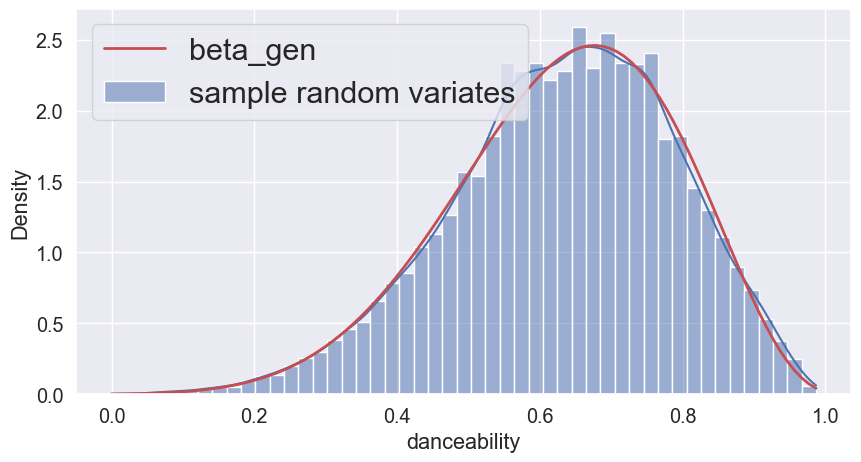

<Figure size 640x480 with 0 Axes>

In [36]:
plot_dist(danceability, scipy.stats.beta)
plt.savefig('danceability_dist.png')

(3.5893015471313223, 1.583072718624745, -0.15881522253171484, 1.1581024745474322)


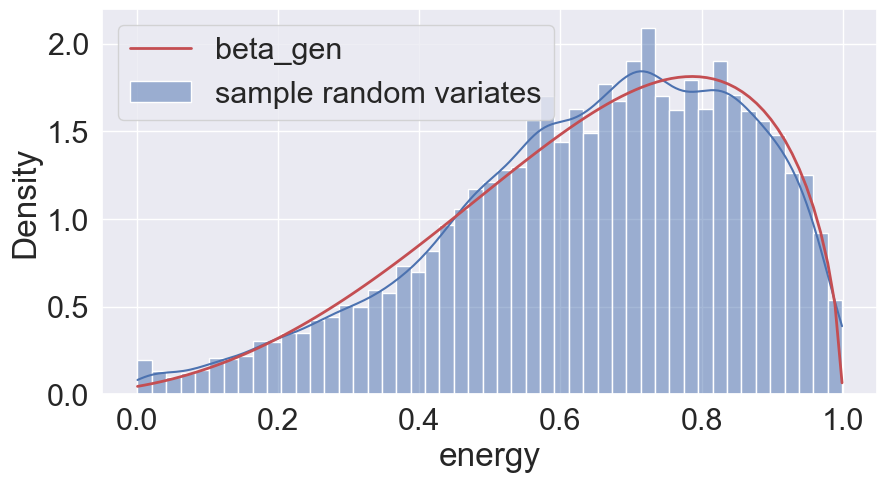

In [37]:
plot_dist(energy, scipy.stats.beta)

(2.122001088748738, 1.6403352454100408, -2.426492113807671, 2.4732519270876496)


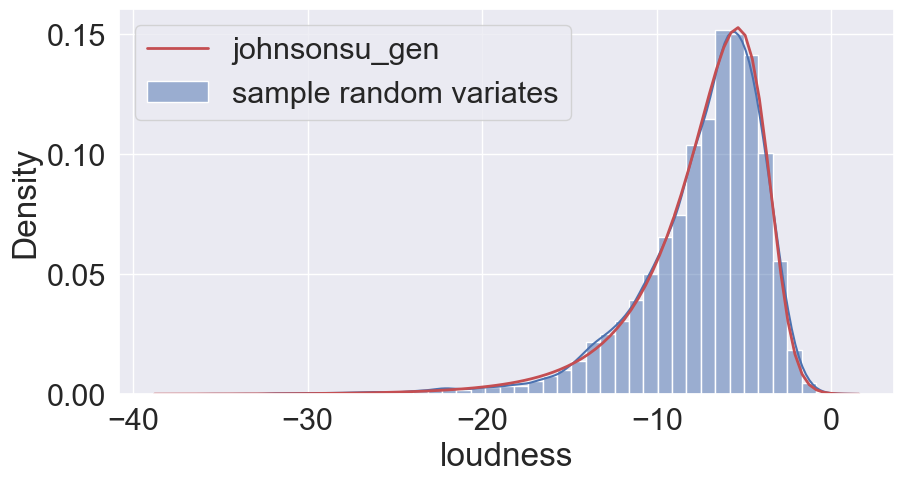

In [38]:
plot_dist(loudness, scipy.stats.johnsonsu)

# Step 5. Parameters estimation

In [43]:
max_likelyhood_danceability = scipy.stats.beta.fit(danceability)

def func(x):
  y_true, bins = np.histogram(danceability, bins=3000, density=True)
  y_dist =  scipy.stats.beta.pdf(bins[1:], x[0], x[1], loc=x[2], scale=x[3])
  return mse(y_true, y_dist)

x0 = [1, 1, 0, 1]
least_squares_danceability = minimize(func, x0, method='Nelder-Mead', tol=1e-6).x

print("danceability")
print("Maximal likelyhood ", max_likelyhood_danceability)
print("Least squares ", least_squares_danceability)

danceability
Maximal likelyhood  (8.852157710187019, 4.078166268703384, -0.23037409700995667, 1.2617187963082035)
Least squares  [17.09520904  7.07341056 -0.59119833  1.73412512]


In [44]:
max_likelyhood_energy = scipy.stats.beta.fit(energy)

def func(x):
  y_true, bins = np.histogram(energy, bins=3000, density=True)
  y_dist =  scipy.stats.beta.pdf(bins[1:], x[0], x[1], loc=x[2], scale=x[3])
  return mse(y_true, y_dist)

x0 = [1, 1, 0, 1]
least_squares_energy = minimize(func, x0, method='Nelder-Mead', tol=1e-6).x

print("energy")
print("Maximal likelyhood ", max_likelyhood_energy)
print("Least squares ", least_squares_energy)

energy
Maximal likelyhood  (3.5893015471313223, 1.583072718624745, -0.15881522253171484, 1.1581024745474322)
Least squares  [ 4.55390877  1.87062684 -0.25943749  1.28058079]


In [45]:
max_likelyhood_loudness = scipy.stats.johnsonsu.fit(loudness)

def func(x):
  y_true, bins = np.histogram(loudness, bins=3000, density=True)
  y_dist = scipy.stats.johnsonsu.pdf(bins[1:], x[0], x[1], loc=x[2], scale=x[3])
  return mse(y_true, y_dist)

x0 = [1, 1, 1, 1]
least_squares_loudness = minimize(func, x0, method='Nelder-Mead',tol=1e-6).x

print("loudness")
print("Maximal likelyhood ", max_likelyhood_loudness)
print("Least squares ", least_squares_loudness)

loudness
Maximal likelyhood  (2.122001088748738, 1.6403352454100408, -2.426492113807671, 2.4732519270876496)
Least squares  [ 1.90837327  1.57378494 -2.70030372  2.53319709]


# Step 6. q-q plots


In [46]:
sns.set(font_scale=1)

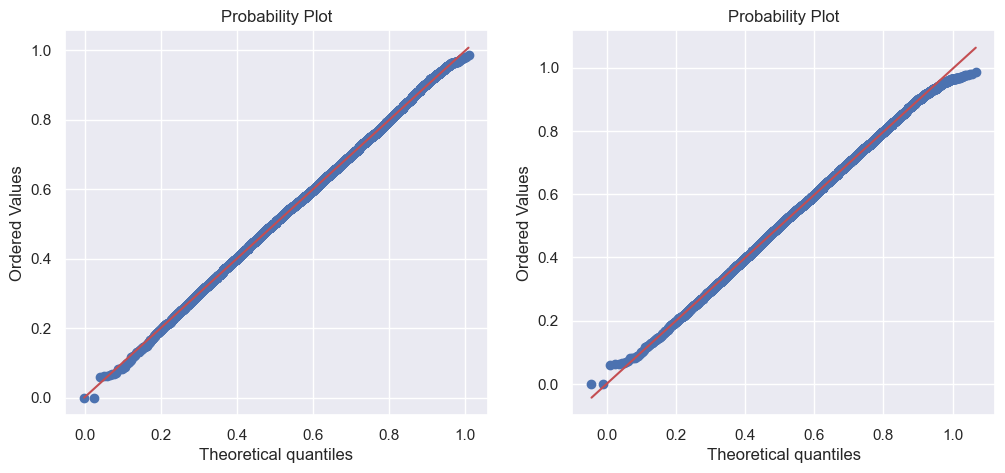

In [47]:
figure, ax = plt.subplots(1, 2, figsize=(12, 5))
scipy.stats.probplot(danceability, dist=scipy.stats.beta, sparams=(max_likelyhood_danceability), plot=ax[0])
scipy.stats.probplot(danceability, dist=scipy.stats.beta, sparams=(least_squares_danceability), plot=ax[1])
plt.savefig('danceability_qq.png')

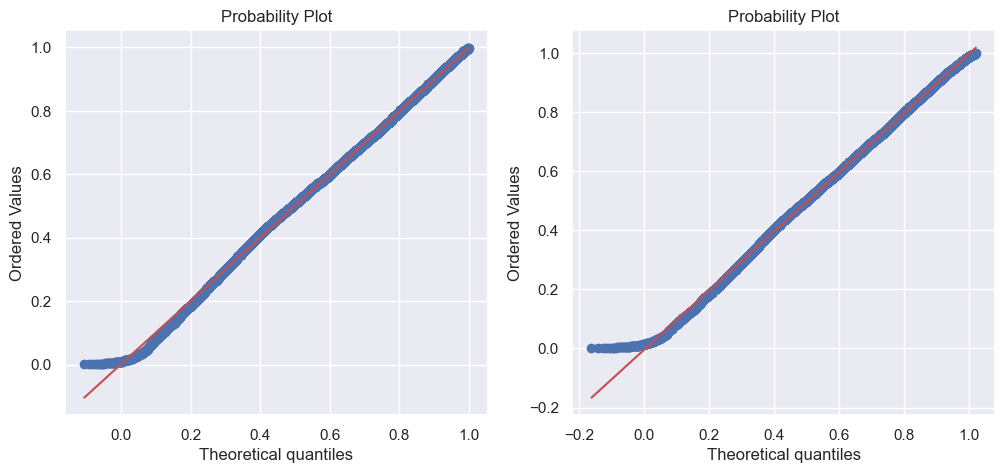

In [48]:
figure, ax = plt.subplots(1, 2, figsize=(12, 5))
scipy.stats.probplot(energy, dist=scipy.stats.beta, sparams=(max_likelyhood_energy), plot=ax[0])
scipy.stats.probplot(energy, dist=scipy.stats.beta, sparams=(least_squares_energy), plot=ax[1])
plt.savefig('energy_qq.png')


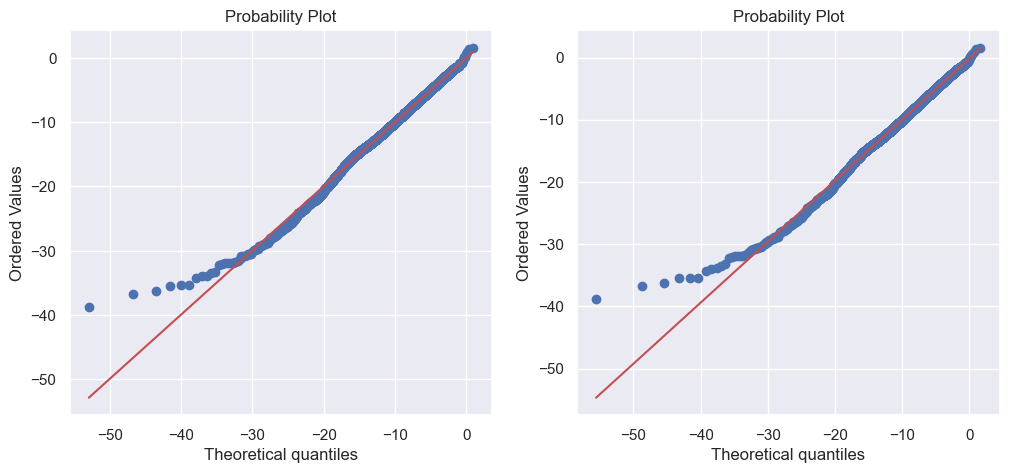

In [49]:
figure, ax = plt.subplots(1, 2, figsize=(12, 5))
scipy.stats.probplot(loudness, dist=scipy.stats.johnsonsu, sparams=(max_likelyhood_loudness), plot=ax[0])
scipy.stats.probplot(loudness, dist=scipy.stats.johnsonsu, sparams=(least_squares_loudness), plot=ax[1])
plt.savefig('loudness_qq.png')

# Step 7. Statistical Tests

In [50]:
print('danceability MLE\n')
print(scipy.stats.kstest(danceability, 'beta', args=max_likelyhood_danceability))
print(scipy.stats.cramervonmises(danceability, 'beta', args=max_likelyhood_danceability))

print('\ndanceability LS\n')
print(scipy.stats.kstest(danceability, 'beta', args=least_squares_danceability))
scipy.stats.cramervonmises(danceability, 'beta', args=least_squares_danceability)

danceability MLE

KstestResult(statistic=0.009476420847041922, pvalue=0.06746821553066829)
CramerVonMisesResult(statistic=0.33221168614484736, pvalue=0.1099697516000957)

danceability LS

KstestResult(statistic=0.009010195957611267, pvalue=0.0933716100453984)


CramerVonMisesResult(statistic=0.23079198340163043, pvalue=0.21497966124676782)

In [51]:
print('energy MLE\n')
print(scipy.stats.kstest(energy, 'beta', args=max_likelyhood_energy))
print(scipy.stats.cramervonmises(energy, 'beta', args=max_likelyhood_energy))

print('\nenergy LS\n')
print(scipy.stats.kstest(energy, 'beta', args=least_squares_energy))
scipy.stats.cramervonmises(energy, 'beta', args=least_squares_energy)

energy MLE

KstestResult(statistic=0.013300093903670068, pvalue=0.0025302333990557366)
CramerVonMisesResult(statistic=0.7063535214323102, pvalue=0.012292749416024429)

energy LS

KstestResult(statistic=0.01362405971748526, pvalue=0.0018212009853897048)


CramerVonMisesResult(statistic=0.5424607918740867, pvalue=0.031125892417962486)

In [52]:
print('loudness \n')
print(scipy.stats.kstest(loudness, 'johnsonsu', args=max_likelyhood_loudness))
print(scipy.stats.cramervonmises(loudness, 'johnsonsu', args=max_likelyhood_loudness))

print('\nloudness LS\n')
print(scipy.stats.kstest(loudness, 'johnsonsu', args=least_squares_loudness))
scipy.stats.cramervonmises(loudness, 'johnsonsu', args=least_squares_loudness)

loudness 

KstestResult(statistic=0.007043941390153741, pvalue=0.30597579450393575)
CramerVonMisesResult(statistic=0.08789290945042535, pvalue=0.6475248813023629)

loudness LS

KstestResult(statistic=0.006034699850505448, pvalue=0.4971039905707114)


CramerVonMisesResult(statistic=0.11117691937235599, pvalue=0.5328168065557584)

# Step 8. Sampling

In [53]:
def plot_proposal_distribution(dist, loc, scale, M, interval, label):
    pdf = dist.pdf
    normal_pdf = scipy.stats.norm(loc, scale).pdf
    x_vals = np.linspace(interval[0]-0.1, interval[1]+0.1, 500)
    pdf_vals = pdf(x_vals)
    normal_vals = normal_pdf(x_vals)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, pdf_vals)
    plt.plot(x_vals, M*normal_vals)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.legend(['theoretical dist', 'norm dist'], fontsize=20)

    plt.title(f"M={M} " + label, fontsize=20)
    return normal_pdf

In [54]:
def rejection_sampling(dist, loc, scale, M, size, label):
    pdf = dist.pdf
    normal_pdf = scipy.stats.norm(loc, scale).pdf
    samples = []
    max_iter = 1.5 * size
    n_iter = 0
    while len(samples) < size or n_iter < max_iter:
        candidate = np.random.normal(loc, scale)

        prob_accept = pdf(candidate) / (M*normal_pdf(candidate))

        if np.random.random() < prob_accept:
            samples.append(candidate)
            
        n_iter += 1
        
    plt.figure(figsize=(10, 5))
    sns.set(font_scale=2)
    sns.histplot(data=samples, bins=bins_num(samples), kde=True, stat='density', label='random variates')
    x = np.linspace(np.min(samples)-0.1, np.max(samples)+0.1, 500)
    pdf = pdf(x)
    plt.plot(x, pdf, 'r-', lw=2, label='theoretical dist')
    plt.legend()
    plt.title("Rejection sampling: " + label, fontsize=20)
    plt.show()
    return samples

In [55]:
def inverse_transform_sampling(dist, size, label):
    uni_samples = np.random.uniform(low=0.0, high=1.0, size=size)
    sample = dist.ppf(uni_samples)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set(font_scale=2)
    plt.rcParams['font.size'] = '20'
    sns.histplot(data=sample, kde=True, ax=ax, bins=bins_num(sample), stat='density', label='random variates')
    
    x = np.linspace(np.min(sample)-0.1, np.max(sample)+0.1, 500)
    y = dist.pdf(x)
    ax.plot(x, y, 'r-', lw=2, label='theoretical dist')
    plt.legend()
    plt.title("Inverse transform sampling: " + label, fontsize=20)
    plt.show()
    return sample
    

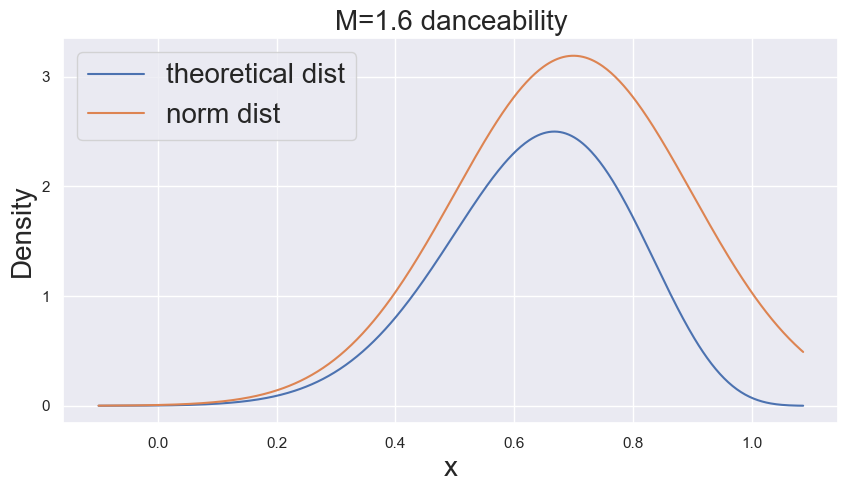

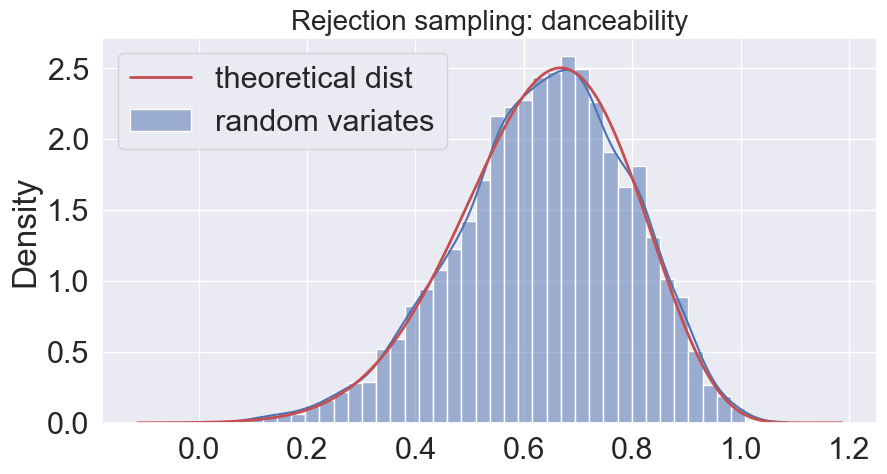

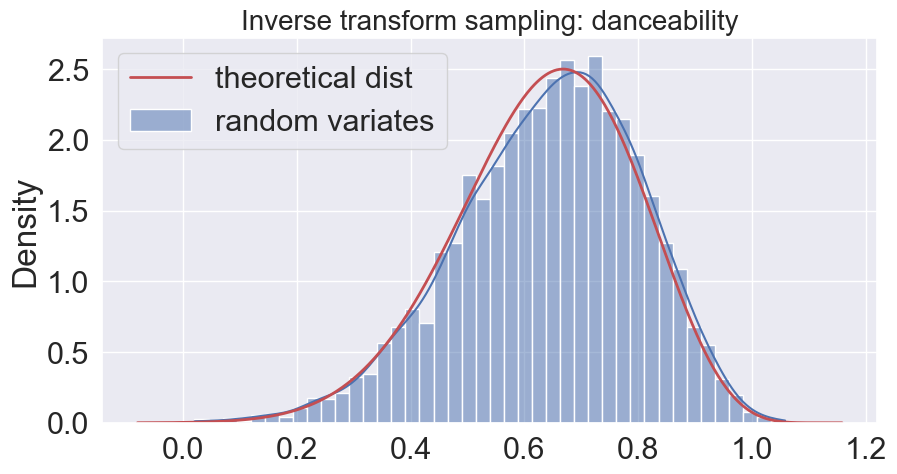

In [56]:
label = "danceability"

dist = scipy.stats.beta(*least_squares_danceability)
loc = 0.7
scale = 0.2
M = 1.6
interval = [danceability.min(), danceability.max()]

plot_proposal_distribution(dist, loc, scale, M, interval, label)
rej_sample = rejection_sampling(dist, loc, scale, M, 5000, label)
inv_sample = inverse_transform_sampling(dist, 5000, label)

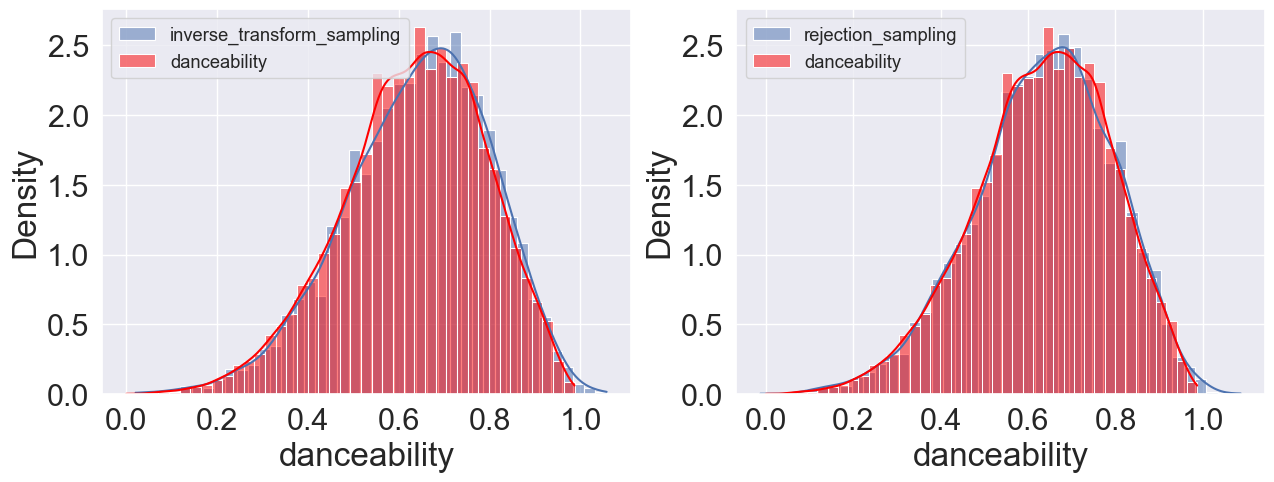

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.set(font_scale=1.2)
plt.rcParams['font.size'] = '20'
sns.histplot(data=inv_sample, kde=True, ax=ax[0], bins=bins_num(inv_sample), stat='density', label='inverse_transform_sampling')
sns.histplot(data=danceability, kde=True, ax=ax[0], bins=bins_num(inv_sample), stat='density', label='danceability', color='red')
ax[0].legend()
sns.histplot(data=rej_sample, kde=True, ax=ax[1], bins=bins_num(rej_sample), stat='density', label='rejection_sampling')
sns.histplot(data=danceability, kde=True, ax=ax[1], bins=bins_num(rej_sample), stat='density', label='danceability', color='red')
ax[1].legend()

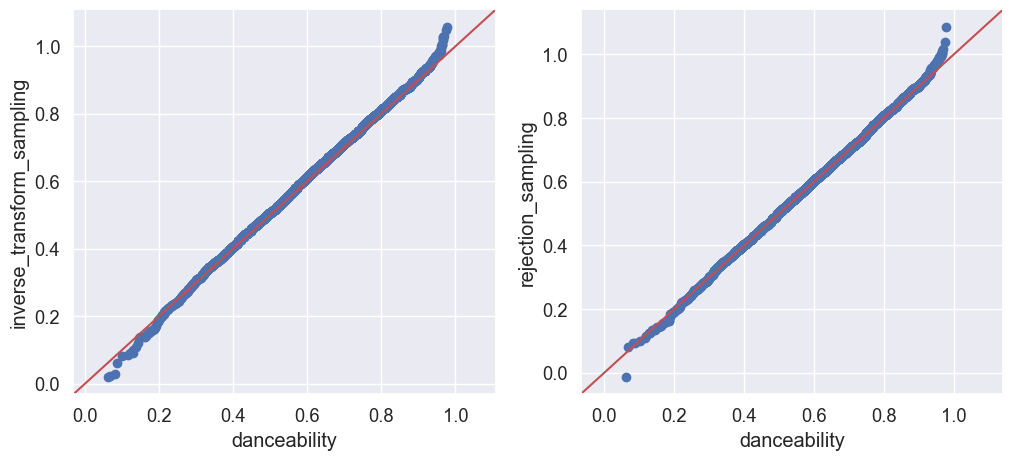

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
pp_x = sm.ProbPlot(danceability)
pp_y = sm.ProbPlot(inv_sample)
pp_z = sm.ProbPlot(np.array(rej_sample))
qqplot_2samples(pp_x, pp_y, xlabel='danceability', ylabel='inverse_transform_sampling', line="45", ax=ax[0])
qqplot_2samples(pp_x, pp_z, xlabel='danceability', ylabel='rejection_sampling', line="45", ax=ax[1])
plt.show()

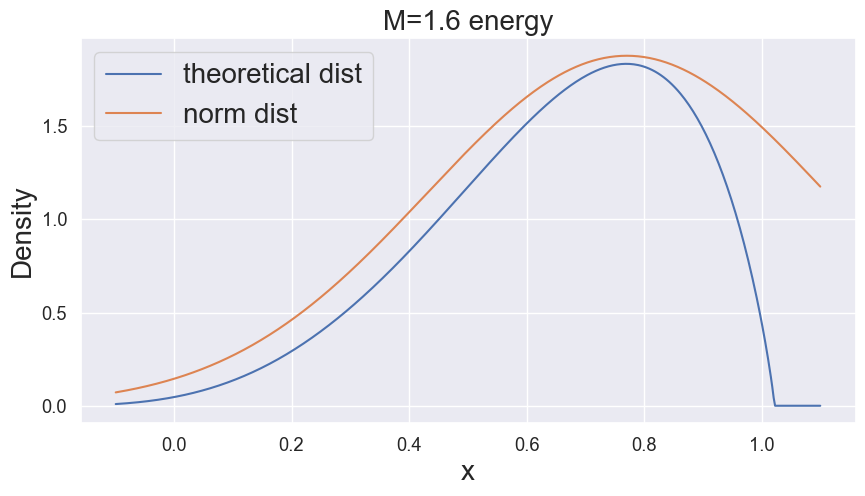

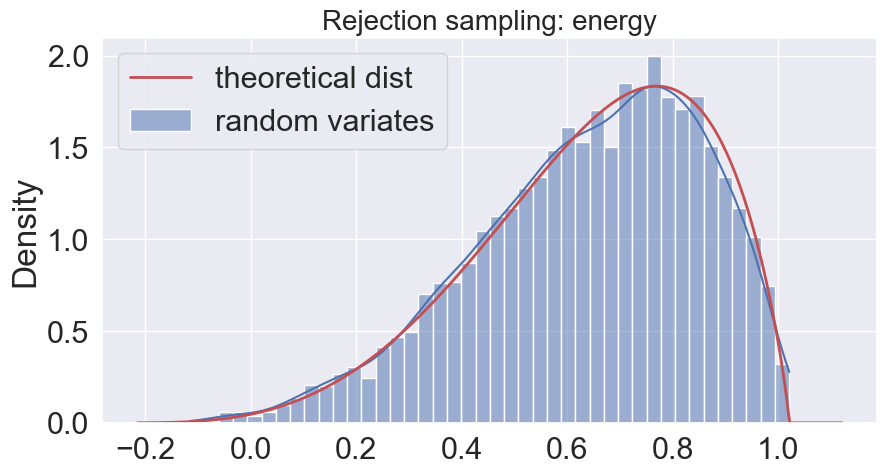

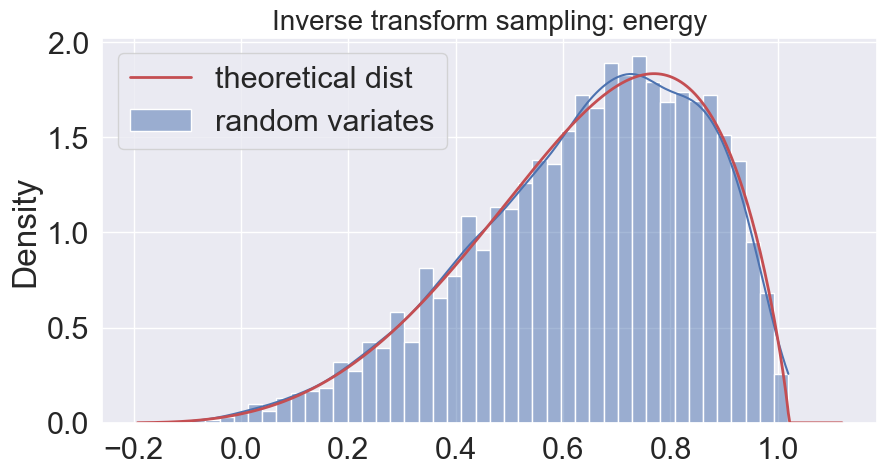

In [59]:
label = "energy"

dist = scipy.stats.beta(*least_squares_energy)
loc = 0.77
scale = 0.34
M = 1.6
interval = [energy.min(), energy.max()]

plot_proposal_distribution(dist, loc, scale, M, interval, label)
rej_sample = rejection_sampling(dist, loc, scale, M, 5000, label)
inv_sample = inverse_transform_sampling(dist, 5000, label)

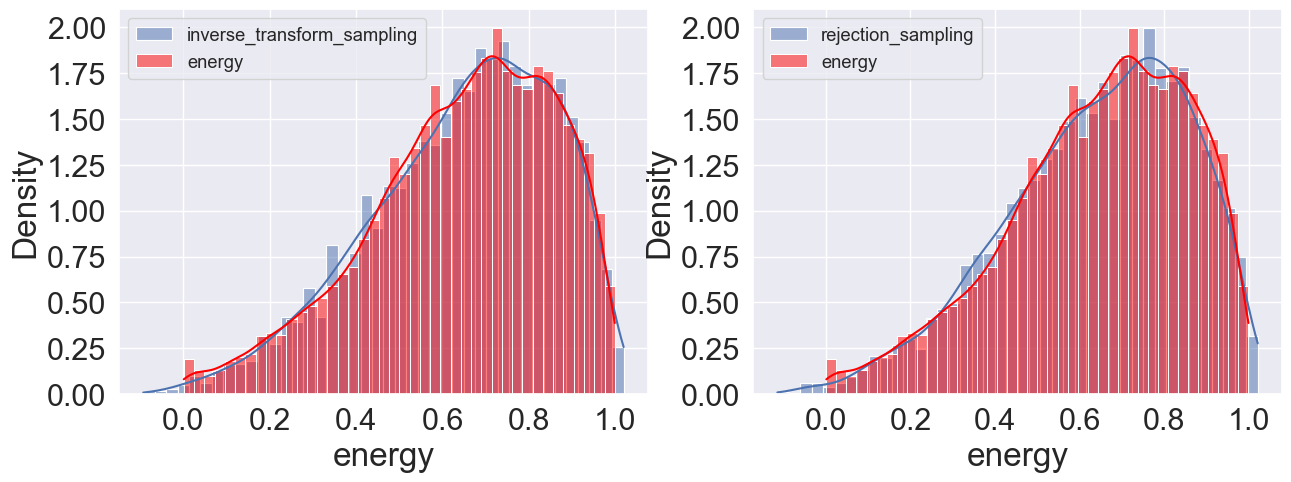

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.set(font_scale=1.2)
plt.rcParams['font.size'] = '15'
sns.histplot(data=inv_sample, kde=True, ax=ax[0], bins=bins_num(inv_sample), stat='density', label='inverse_transform_sampling')
sns.histplot(data=energy, kde=True, ax=ax[0], bins=bins_num(inv_sample), stat='density', label='energy', color='red')
ax[0].legend()
sns.histplot(data=rej_sample, kde=True, ax=ax[1], bins=bins_num(rej_sample), stat='density', label='rejection_sampling')
sns.histplot(data=energy, kde=True, ax=ax[1], bins=bins_num(rej_sample), stat='density', label='energy', color='red')
ax[1].legend()

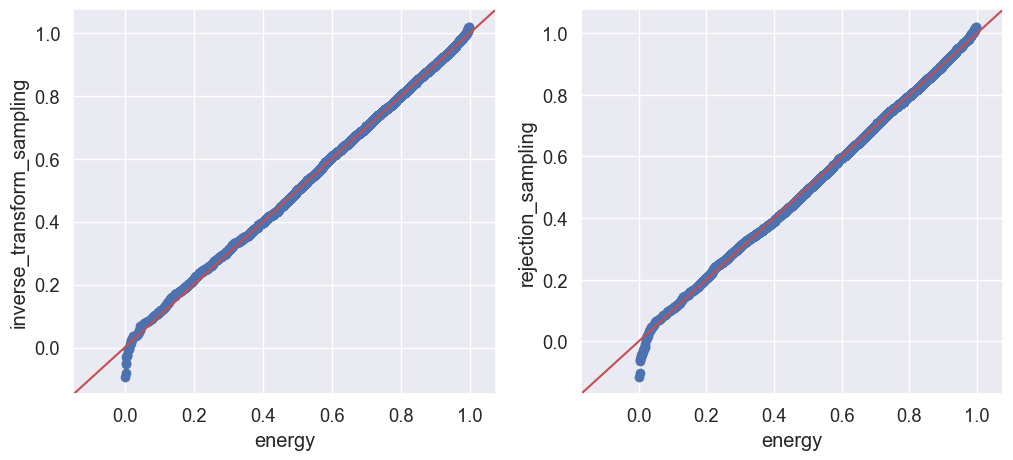

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
pp_x = sm.ProbPlot(energy)
pp_y = sm.ProbPlot(inv_sample)
pp_z = sm.ProbPlot(np.array(rej_sample))
qqplot_2samples(pp_x, pp_y, xlabel='energy', ylabel='inverse_transform_sampling', line="45", ax=ax[0])
qqplot_2samples(pp_x, pp_z, xlabel='energy', ylabel='rejection_sampling', line="45", ax=ax[1])
plt.show()

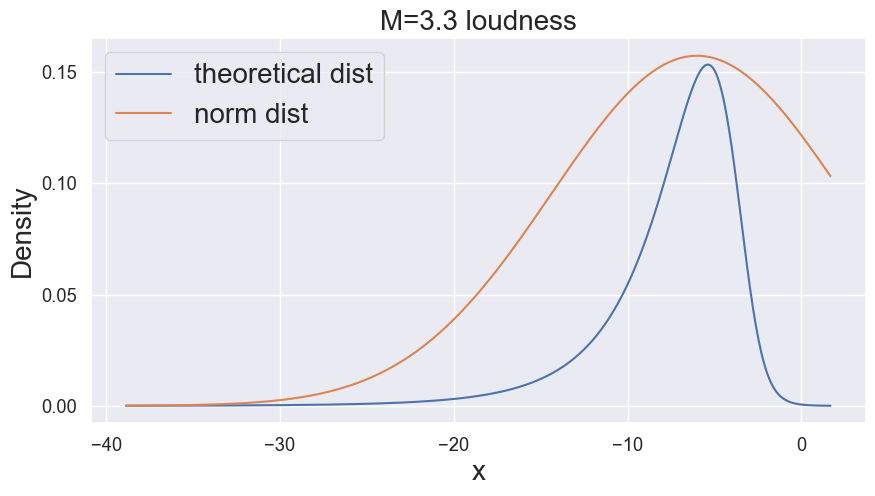

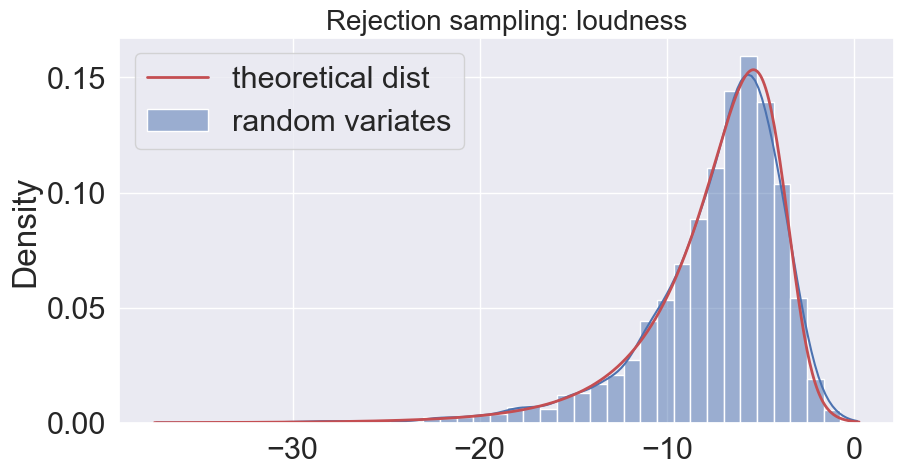

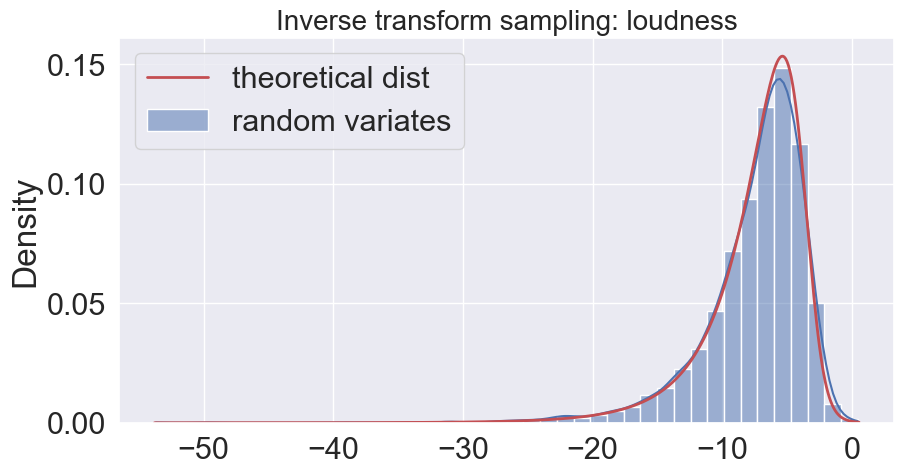

In [62]:
label = "loudness"

dist = scipy.stats.johnsonsu(*least_squares_loudness)
loc = -6
scale = 8.37
M = 3.3
interval = [loudness.min(), loudness.max()]

plot_proposal_distribution(dist, loc, scale, M, interval, label)
rej_sample = rejection_sampling(dist, loc, scale, M, 5000, label)
inv_sample = inverse_transform_sampling(dist, 5000, label)

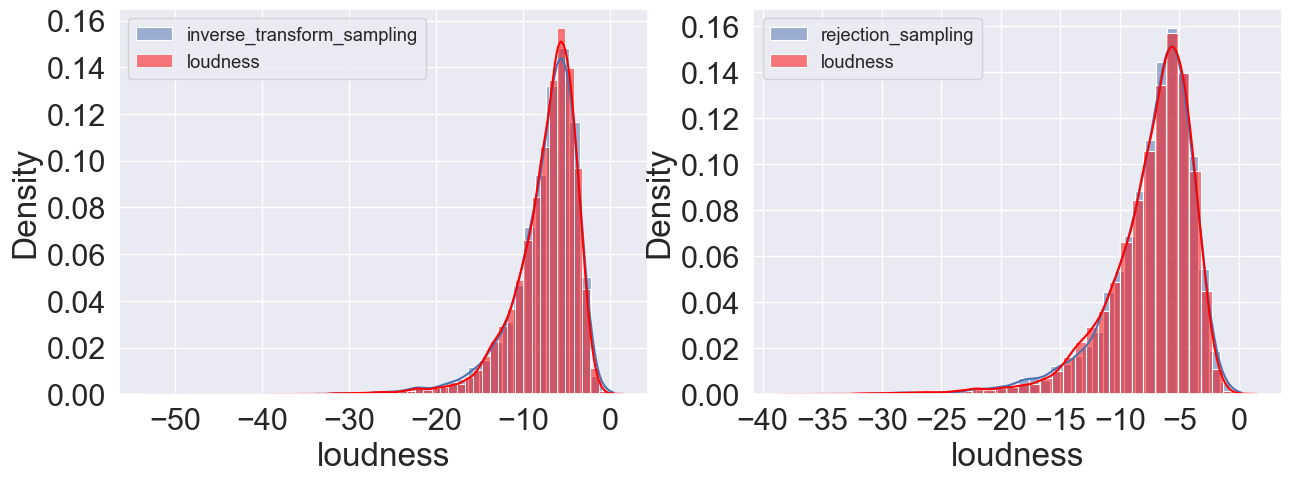

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.set(font_scale=1.2)
plt.rcParams['font.size'] = '15'
sns.histplot(data=inv_sample, kde=True, ax=ax[0], bins=bins_num(inv_sample), stat='density', label='inverse_transform_sampling')
sns.histplot(data=loudness, kde=True, ax=ax[0], bins=bins_num(inv_sample), stat='density', label='loudness', color='red')
ax[0].legend()
sns.histplot(data=rej_sample, kde=True, ax=ax[1], bins=bins_num(rej_sample), stat='density', label='rejection_sampling')
sns.histplot(data=loudness, kde=True, ax=ax[1], bins=bins_num(rej_sample), stat='density', label='loudness', color='red')
ax[1].legend()

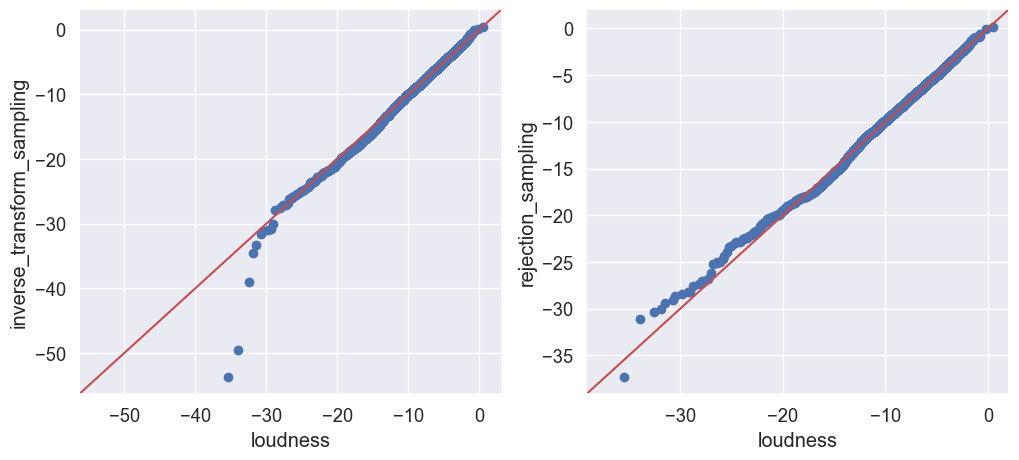

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
pp_x = sm.ProbPlot(loudness)
pp_y = sm.ProbPlot(inv_sample)
pp_z = sm.ProbPlot(np.array(rej_sample))
qqplot_2samples(pp_x, pp_y, xlabel='loudness', ylabel='inverse_transform_sampling', line="45", ax=ax[0])
qqplot_2samples(pp_x, pp_z, xlabel='loudness', ylabel='rejection_sampling', line="45", ax=ax[1])
plt.show()